# Dive Prediction - First Time Passage

*Predicting Seabird Diving Behaviour from GPS data*

This notebook predicts dive with First Time Passage Approach

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.trip import * 

In [93]:
data_test = pd.read_csv('./../data/SV_test_guanape.csv')

## Choose resolution

In [94]:
resolution = 5
data_test_new = change_resolution(data_test, resolution)

data_test_new

,trip,datetime,lon,lat,gaps,dive,step_speed,step_direction
0,G1107_12_SV_T1,2007-11-19 13:42:18,-78.958173,-8.566655,0.0,0,NaN,NaN
1,G1107_12_SV_T1,2007-11-19 13:42:23,-78.958096,-8.566986,0.0,0,7.561325,NaN
2,G1107_12_SV_T1,2007-11-19 13:42:28,-78.958106,-8.567359,0.0,0,8.306816,14.473134
3,G1107_12_SV_T1,2007-11-19 13:42:33,-78.958196,-8.567769,0.0,0,9.340164,10.728200
4,G1107_12_SV_T1,2007-11-19 13:42:38,-78.958359,-8.568248,0.0,0,11.251253,6.351008
...,...,...,...,...,...,...,...,...
53434,G1107_9_SV_T1,2007-11-18 17:41:44,-78.965941,-8.567722,0.0,0,9.524216,28.485340
53435,G1107_9_SV_T1,2007-11-18 17:41:49,-78.965598,-8.567170,0.0,0,14.423293,-73.885990
53436,G1107_9_SV_T1,2007-11-18 17:41:54,-78.965450,-8.566270,0.0,0,20.299387,-22.332355
53437,G1107_9_SV_T1,2007-11-18 17:41:59,-78.965760,-8.565544,0.0,0,17.544234,-32.127179


## Empirical parameters 

In [95]:
## compute distance matrixes
list_trip = []
for i in data_test_new.trip.unique():
    t = data_test_new[data_test_new.trip == i]
    
    trip = Trip(t)
    trip.compute_dist_matrix()
    list_trip.append(trip)

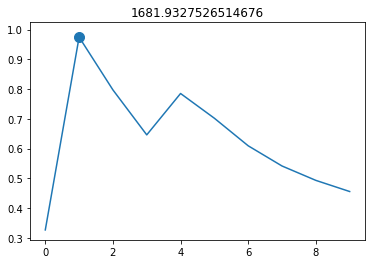

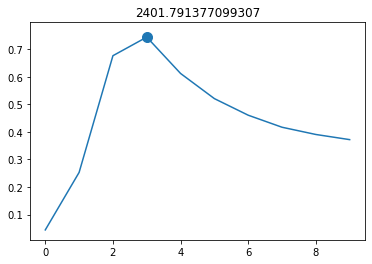

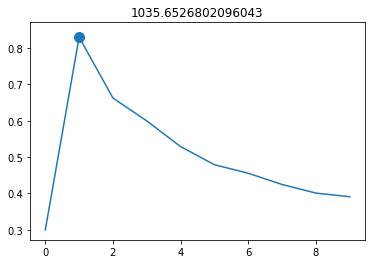

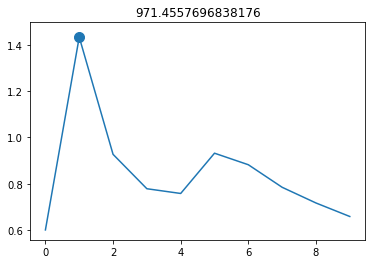

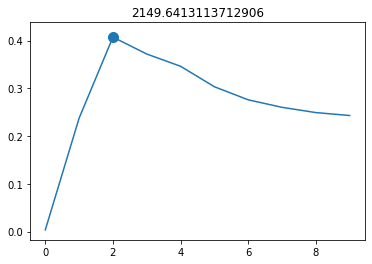

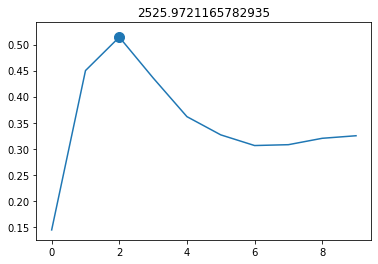

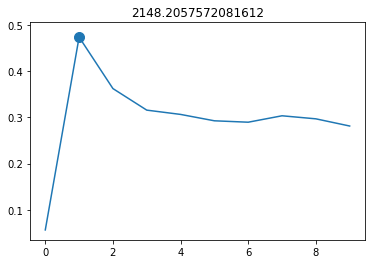

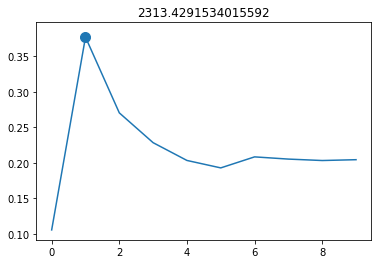

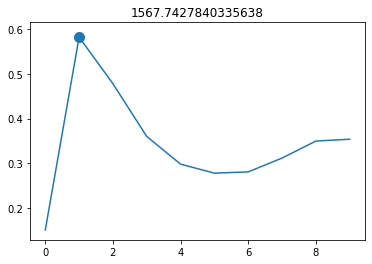

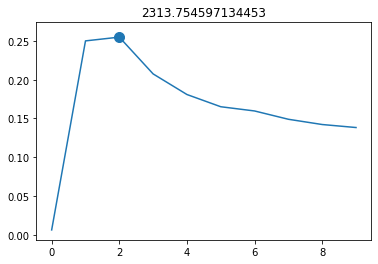

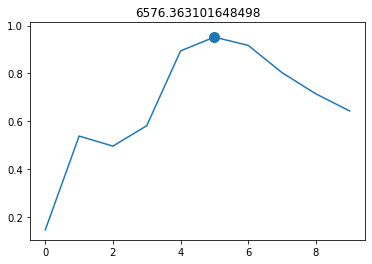

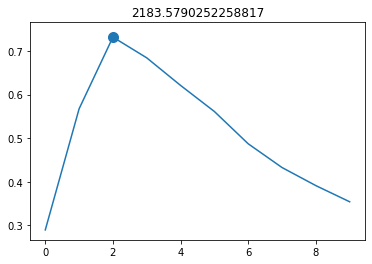

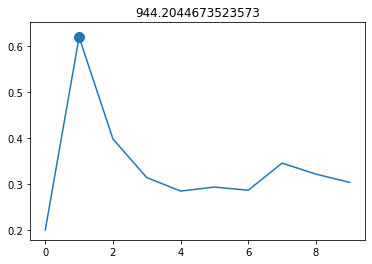

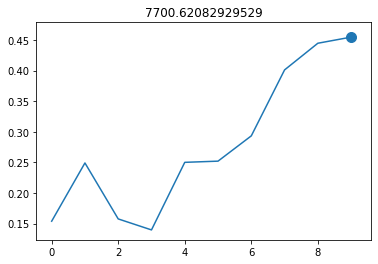

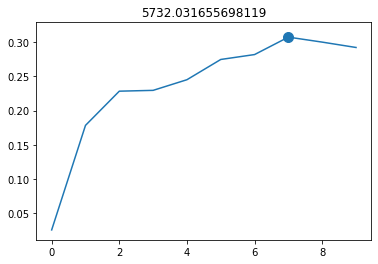

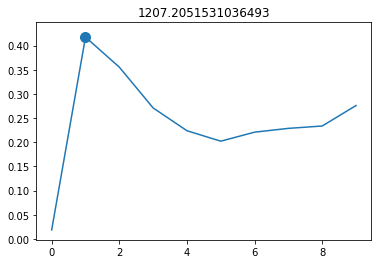

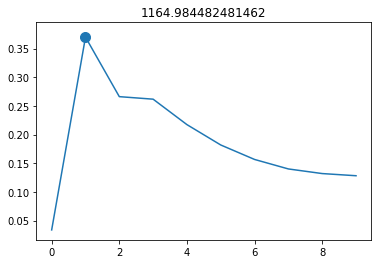

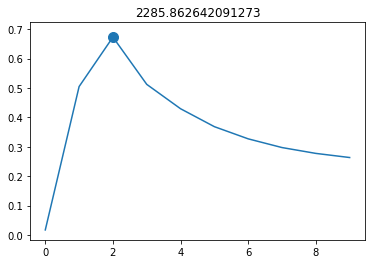

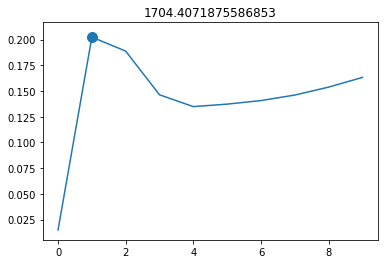

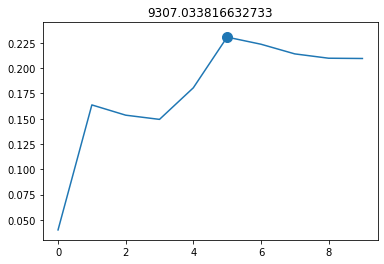

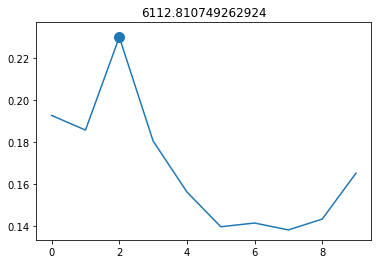

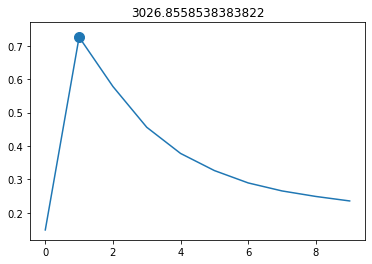

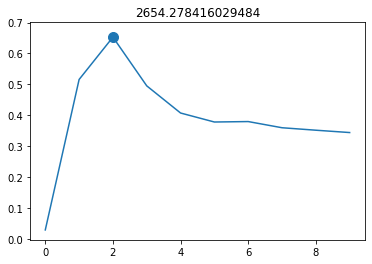

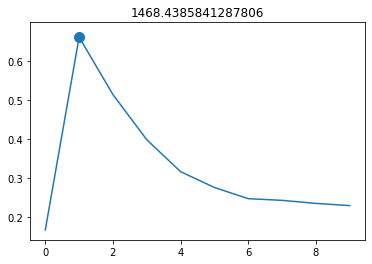

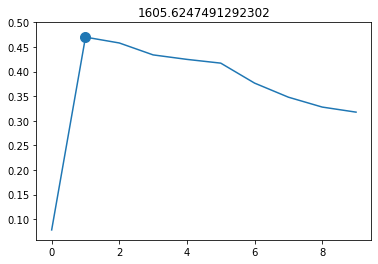

In [96]:
## compute first time passage
list_ftp = []
for trip in list_trip:
    
    ### radius selection
    radius = np.arange(10, np.max(trip.dist_matrix)/3, np.max(trip.dist_matrix)/30 )
    var = []
    for r in radius:
        ftp = trip.first_time_passage(r)
        var.append(np.var(np.log(ftp)))

    R = radius[np.argmax(var)]

    plt.plot(np.array(var))
    plt.scatter(np.argmax(var), np.max(var), s = 100)
    plt.title(R)
    plt.show()
    
    ### FPT computation
    ftp = trip.first_time_passage(R)
    ftp = ftp/max(ftp)
    ftp[ftp < 1e-5] = 1e-5
    ftp[ftp > 1-1e-5] = 1-1e-5
    
    list_ftp.append(ftp)

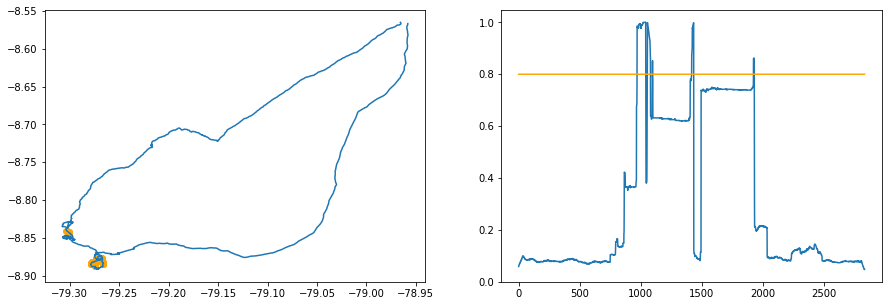

In [97]:
time_threshold = 0.8

i = 0

trip = list_trip[i]
ftp = list_ftp[i]

plt.figure(figsize = (15, 5))
plt.subplot(1,2,1)
plt.plot(np.array(trip.df.lon), np.array(trip.df.lat))
plt.scatter(trip.df.lon.values[ftp>time_threshold], \
            trip.df.lat.values[ftp>time_threshold], c = 'orange')

plt.subplot(1,2,2)
plt.plot(ftp)
plt.plot(time_threshold*np.ones(len(ftp)), c = 'orange')

In [98]:
data_test_new['prediction'] = np.hstack(list_ftp)
data_test_new.to_csv('./../results/SV_ftp_GNP.csv', index = False)

In [99]:
def roc(data, opt = ''):
    # globally
    TP = []
    FP = []
    
    if opt == 'all':
        scale = data.prediction.sort_values().unique()
    else:
        scale = np.arange(0,1,0.001)
        
    for tt in scale:
        all_estim = 1* (data.prediction > tt)
        true_positive = np.mean(all_estim[data.dive == 1])
        true_negative = 1-np.mean(all_estim[data.dive == 0])
        TP.append(true_positive)
        FP.append(1-true_negative)
        
    return (np.array(FP), np.array(TP))

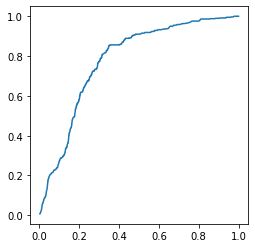

In [100]:
FP, TP = roc(data_test_new)

plt.figure()
ax = plt.gca()
ax.set_aspect(1)

plt.plot(FP, TP)

In [101]:
-np.trapz(TP, FP)

0.7793041224962521

## compute loss

In [102]:
def loss(x, y, weight):
    return np.mean(-(weight*y*np.log(x) + (1-y)*np.log(1-x)))

In [103]:
loss(data_test_new.prediction, data_test_new.dive, 30)

0.9272596934915727